In [2]:
pip install datasets

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import get_scheduler
from tqdm.auto import tqdm
import transformers

In [4]:
data = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [6]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def tokenize_function(example):
    return tokenizer(example['text'], padding = 'max_length', truncation = True, max_length = 512)

In [8]:
tokenized_data = data.map(tokenize_function, batched = True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [9]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [10]:
train_dataset = tokenized_data["train"].shuffle(seed = 42).select(range(10000))
test_dataset = tokenized_data["test"].shuffle(seed = 42).select(range(2000))

In [11]:
train_dataset.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])

In [12]:
train_dataset = train_dataset.rename_column('label', 'labels')
test_dataset = test_dataset.rename_column('label', 'labels')

In [13]:
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size = 8, collate_fn = data_collator)
test_dataloader = DataLoader(test_dataset, batch_size = 8, collate_fn = data_collator)

In [14]:
def train_model(model, dataloader, optimizer, lr_scheduler, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    return total_loss/len(dataloader)

In [15]:
def evaluation(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            preds = outputs.logits.argmax(dim = -1)
            correct_preds += (preds == batch['labels']).sum().item()
            total += len(batch['labels'])

    return total_loss/len(dataloader), correct_preds/total

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 2

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
optimizer = optim.AdamW(model.parameters(), lr = 5e-5)
num_steps = epochs * len(train_dataloader)

lr_scheduler = get_scheduler(name = 'linear', optimizer = optimizer, num_training_steps = num_steps, num_warmup_steps = 0)

In [ ]:
for epoch in range(epochs):
    train_loss = train_model(model, train_dataloader, optimizer, lr_scheduler, device)
    test_loss, test_accuracy = evaluation(model, test_dataloader, device)

    print(f'Epoch {epoch + 1}')
    print(f'Training Loss: {train_loss: .3f}')
    print(f'Testing Loss: {test_loss: .3f}')
    print(f'Accuracy: {test_accuracy: .3f}')

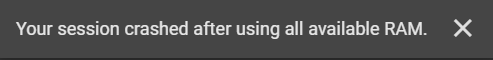

In [1]:
#the session keeps crashing for the last cell